# Reinforcement Learning Practice 1
 _by Hotae Lee_
* Q network - FrozenLake
* Q network - CartPole
* DQN 2013(Deeper Network & replay buffer) - CartPole
* DQN 2015(Use double network to solve unstationary target) -CartPole
* Policy Gradient (Actor-Critic) - CartPole
* Make test environment
* Q Network for 3 WMRs

### Q network - FrozenLake

Percent of successful episodes: 0.489%


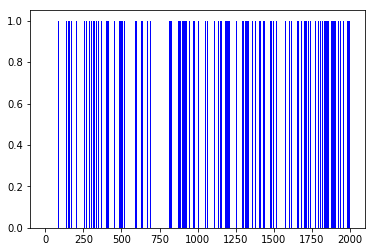

In [6]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

# These lines establish the feed-forward part of the network used to
# choose actions
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)  # state input
W = tf.Variable(tf.random_uniform(
    [input_size, output_size], 0, 0.01))  # weight

Qpred = tf.matmul(X, W)  # Out Q prediction
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)  # Y label

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Set Q-learning related parameters
dis = .99
num_episodes = 2000

# Create lists to contain total rewards and steps per episode
rList = []
    

def one_hot(x):
    return np.identity(16)[x:x + 1]

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # The Q-Network training
        while not done:
            # Choose an action by greedily (with e chance of random action)
            # from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a terminal state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s1 values by feeding the new state through our
                # network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis * np.max(Qs1)

            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1
        rList.append(rAll)

print("Percent of successful episodes: " +
      str(sum(rList) / num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

### CartPole Random action test

In [11]:
import gym

env = gym.make('CartPole-v0')
env.reset()
random_episodes = 0
reward_sum = 0
while random_episodes < 10:
    env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    print(observation, reward, done)
    reward_sum += reward
    if done:
        random_episodes += 1
        print("Reward for this episode was:", reward_sum)
        reward_sum = 0
env.reset()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(array([-0.00062584,  0.20521483, -0.02730596, -0.32927179]), 1.0, False)
(array([ 0.00347845,  0.40071464, -0.03389139, -0.63043915]), 1.0, False)
(array([ 0.01149275,  0.5962927 , -0.04650018, -0.93359993]), 1.0, False)
(array([ 0.0234186 ,  0.7920101 , -0.06517217, -1.24052482]), 1.0, False)
(array([ 0.0392588 ,  0.9879055 , -0.08998267, -1.55289116]), 1.0, False)
(array([ 0.05901691,  1.18398371, -0.12104049, -1.87223779]), 1.0, False)
(array([ 0.08269659,  1.38020241, -0.15848525, -2.19991147]), 1.0, False)
(array([ 0.11030063,  1.57645655, -0.20248348, -2.53700319]), 1.0, False)
(array([ 0.14182977,  1.38346807, -0.25322354, -2.31255875]), 1.0, True)
('Reward for this episode was:', 9.0)
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavi

array([ 0.04890821, -0.00819998,  0.04947044,  0.00126633])

### Q Network - CartPole

In [1]:
'''
This code is based on
https://github.com/hunkim/DeepRL-Agents
'''
import numpy as np
import tensorflow as tf
from collections import deque

import gym
env = gym.make('CartPole-v0')

# Constants defining our neural network
learning_rate = 1e-1
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

X = tf.placeholder(tf.float32, [None, input_size], name = "input_x")

# First layer of weights
W1 = tf.get_variable("W1", shape=[input_size, output_size],
                    initializer=tf.contrib.layers.xavier_initializer())
Qpred = tf.matmul(X, W1)

# We need to define the parts of the network needed for learning a policy
Y = tf.placeholder(shape=[None, output_size], dtype=tf.float32)

# Loss function
loss = tf.reduce_sum(tf.square(Y - Qpred))
# Learning
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Values for q learning
max_episodes = 5000
dis = 0.9
step_history = []


# Setting up our environment
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for episode in range(max_episodes):
    e = 1. / ((episode / 10) + 1)
    step_count = 0
    state = env.reset()
    done = False

    # The Q-Network training
    while not done:
        step_count += 1
        x = np.reshape(state, [1, input_size])
        # Choose an action by greedily (with e chance of random action) from
        # the Q-network
        Q = sess.run(Qpred, feed_dict={X: x})
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q)

        # Get new state and reward from environment
        next_state, reward, done, _ = env.step(action)
        if done:
            Q[0, action] = -100
        else:
            x_next = np.reshape(next_state, [1, input_size])
            # Obtain the Q' values by feeding the new state through our network
            Q_next = sess.run(Qpred, feed_dict={X: x_next})
            Q[0, action] = reward + dis * np.max(Q_next)

        # Train our network using target and predicted Q values on each episode
        sess.run(train, feed_dict={X: x, Y: Q})
        state = next_state

    step_history.append(step_count)
    print("Episode: {}  steps: {}".format(episode, step_count))
    # If last 10's avg steps are 500, it's good enough
    if len(step_history) > 10 and np.mean(step_history[-10:]) > 500:
        break

# See our trained network in action
observation = env.reset()
reward_sum = 0
while True:
    env.render()

    x = np.reshape(observation, [1, input_size])
    Q = sess.run(Qpred, feed_dict={X: x})
    action = np.argmax(Q)

    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    if done:
        print("Total score: {}".format(reward_sum))
break

/home/hotae319/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Episode: 0  steps: 16
Episode: 1  steps: 15
Episode: 2  steps: 20
Episode: 3  steps: 11
Episode: 4  steps: 16
Episode: 5  steps: 20
Episode: 6  steps: 17
Episode: 7  steps: 19
Episode: 8  steps: 16
Episode: 9  steps: 21
Episode: 10  steps: 10
Episode: 11  steps: 12
Episode: 12  steps: 18
Episode: 13  steps: 13
Episode: 14  steps: 11
Episode: 15  steps: 12
Episode: 16  steps: 8
Episode: 17  steps: 10
Episode: 18  steps: 15
Episode: 19  steps: 9
Episode: 20  steps: 10
Episode: 21  steps: 10
Episode: 22  steps: 10
Episode: 23  steps: 12
Episode: 24  steps: 70
Episode: 25  steps: 61
Episode: 26  steps: 32
Episode: 27  steps: 61
Episode: 28  steps: 22
Episode: 29  steps: 22
Episode: 30  steps: 10
Episode: 31  steps: 41
Episode: 32  steps: 36
Episode: 33  steps: 23
Episode: 34  steps: 19
Episode: 35  steps: 10
Episode: 36  steps: 11
Episode: 37  steps: 9
Episode: 38  steps: 9
Episode: 39  steps:

KeyboardInterrupt: 

## DQN NIPS2013 TEST
* by _sung kim_

about cart_pole using DQN

In [2]:
"""
DQN (NIPS 2013)
Playing Atari with Deep Reinforcement Learning
https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
"""
import numpy as np
import tensorflow as tf
import random
import dqn
import gym
from collections import deque

env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, 'gym-results/', force=True)
INPUT_SIZE = env.observation_space.shape[0]
OUTPUT_SIZE = env.action_space.n

DISCOUNT_RATE = 0.99
REPLAY_MEMORY = 50000
MAX_EPISODE = 5000
BATCH_SIZE = 64

# minimum epsilon for epsilon greedy
MIN_E = 0.0
# epsilon will be `MIN_E` at `EPSILON_DECAYING_EPISODE`
EPSILON_DECAYING_EPISODE = MAX_EPISODE * 0.01


def bot_play(mainDQN):
    """Runs a single episode with rendering and prints a reward
    Args:
        mainDQN (dqn.DQN): DQN Agentbot_play
    """
    state = env.reset()
    total_reward = 0

    while True:
        env.render()
        action = np.argmax(mainDQN.predict(state))
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            print("Total score: {}".format(total_reward))
            break


def train_minibatch(DQN, train_batch):
    """Prepare X_batch, y_batch and train them
    Recall our loss function is
        target = reward + discount * max Q(s',a)
                 or reward if done early
        Loss function: [target - Q(s, a)]^2
    Hence,
        X_batch is a state list
        y_batch is reward + discount * max Q
                   or reward if terminated early
    Args:
        DQN (dqn.DQN): DQN Agent to train & run
        train_batch (list): Minibatch of Replay memory
            Eeach element is a tuple of (s, a, r, s', done)
    Returns:
        loss: Returns a loss
    """
    state_array = np.vstack([x[0] for x in train_batch])
    action_array = np.array([x[1] for x in train_batch])
    reward_array = np.array([x[2] for x in train_batch])
    next_state_array = np.vstack([x[3] for x in train_batch])
    done_array = np.array([x[4] for x in train_batch])

    X_batch = state_array
    y_batch = DQN.predict(state_array) #training by Neural Net

    Q_target = reward_array + DISCOUNT_RATE * np.max(DQN.predict(next_state_array), axis=1) * ~done_array
    y_batch[np.arange(len(X_batch)), action_array] = Q_target

    # Train our network using target and predicted Q values on each episode
    loss, _ = DQN.update(X_batch, y_batch)
   
    return loss


def annealing_epsilon(episode, min_e, max_e, target_episode):
    """Return an linearly annealed epsilon
    Epsilon will decrease over time until it reaches `target_episode`
         (epsilon)
             |
    max_e ---|\
             | \
             |  \
             |   \
    min_e ---|____\_______________(episode)
                  |
                 target_episode
     slope = (min_e - max_e) / (target_episode)
     intercept = max_e
     e = slope * episode + intercept
    Args:
        episode (int): Current episode
        min_e (float): Minimum epsilon
        max_e (float): Maximum epsilon
        target_episode (int): epsilon becomes the `min_e` at `target_episode`
    Returns:
        float: epsilon between `min_e` and `max_e`
    """

    slope = (min_e - max_e) / (target_episode)
    intercept = max_e

    return max(min_e, slope * episode + intercept)


def main():
    # store the previous observations in replay memory
    replay_buffer = deque(maxlen=REPLAY_MEMORY) 
    last_100_game_reward = deque(maxlen=100)

    with tf.Session() as sess:
        mainDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE)
        init = tf.global_variables_initializer()
        sess.run(init)
        loss = 0

        for episode in range(MAX_EPISODE):
            e = annealing_epsilon(episode, MIN_E, 1.0, EPSILON_DECAYING_EPISODE)
            done = False
            state = env.reset()            

            step_count = 0
            while not done:

                if np.random.rand() < e:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(mainDQN.predict(state))

                next_state, reward, done, _ = env.step(action)

                if done:
                    reward = -100

                replay_buffer.append((state, action, reward, next_state, done))

                state = next_state
                step_count += 1

                if len(replay_buffer) > BATCH_SIZE:
                    minibatch = random.sample(replay_buffer, BATCH_SIZE)
                    loss = train_minibatch(mainDQN, minibatch)

            print("[Episode {:>5}]  steps: {:>5} e: {:>5.2f}  loss: {}".format(episode, step_count, e, loss))
            

            # CartPole-v0 Game Clear Logic
            last_100_game_reward.append(step_count)
            if len(last_100_game_reward) == last_100_game_reward.maxlen:
                avg_reward = np.mean(last_100_game_reward)
                if avg_reward > 199.0:
                    print("Game Cleared within {} episodes with avg reward {}".format(episode, avg_reward))
                    break


if __name__ == "__main__":
    main()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
[Episode     0]  steps:    17 e:  1.00  loss: 0
[Episode     1]  steps:     9 e:  0.98  loss: 0
[Episode     2]  steps:    21 e:  0.96  loss: 0
[Episode     3]  steps:    12 e:  0.94  loss: 0
[Episode     4]  steps:     9 e:  0.92  loss: 388.61706543
[Episode     5]  steps:    12 e:  0.90  loss: 309.770690918
[Episode     6]  steps:    11 e:  0.88  loss: 232.552307129
[Episode     7]  steps:    16 e:  0.86  loss: 385.866149902
[Episode     8]  steps:    20 e:  0.84  loss: 461.846435547
[Episode     9]  steps:    23 e:  0.82  loss: 306.743713379
[Episode    10]  steps:    13 e:  0.80  loss: 307.124389648
[Episode    11]  steps:    16 e:  0.78  loss: 229.019256592
[Episode    12]  steps:    12 e:  0.76  loss: 304.277832031
[Episode    13]  steps:    24 e:  0.74  loss: 227.81817627
[Episode    14]  steps:    12 e:  0.72  loss: 227.852508545
[Episode    15]  steps:    12 e:  0.70  loss: 222.83

[Episode   138]  steps:    44 e:  0.00  loss: 44.8855323792
[Episode   139]  steps:   194 e:  0.00  loss: 43.7727394104
[Episode   140]  steps:    50 e:  0.00  loss: 78.2951126099
[Episode   141]  steps:    58 e:  0.00  loss: 3.40687179565
[Episode   142]  steps:    66 e:  0.00  loss: 72.8000640869
[Episode   143]  steps:    55 e:  0.00  loss: 5.88366985321
[Episode   144]  steps:    99 e:  0.00  loss: 15.7391824722
[Episode   145]  steps:    48 e:  0.00  loss: 72.1005859375
[Episode   146]  steps:    56 e:  0.00  loss: 47.8727264404
[Episode   147]  steps:    71 e:  0.00  loss: 13.906036377
[Episode   148]  steps:    81 e:  0.00  loss: 28.3537902832
[Episode   149]  steps:    74 e:  0.00  loss: 4.16057872772
[Episode   150]  steps:    72 e:  0.00  loss: 4.02708292007
[Episode   151]  steps:    64 e:  0.00  loss: 15.1226110458
[Episode   152]  steps:    63 e:  0.00  loss: 4.22234773636
[Episode   153]  steps:   104 e:  0.00  loss: 22.5192222595
[Episode   154]  steps:    92 e:  0.00  l

[Episode   275]  steps:   200 e:  0.00  loss: 5.87952232361
[Episode   276]  steps:   200 e:  0.00  loss: 86.4215240479
[Episode   277]  steps:   200 e:  0.00  loss: 3.19387102127
[Episode   278]  steps:   200 e:  0.00  loss: 5.60913610458
[Episode   279]  steps:   200 e:  0.00  loss: 3.16126680374
[Episode   280]  steps:   200 e:  0.00  loss: 2.57448720932
[Episode   281]  steps:   200 e:  0.00  loss: 182.597869873
[Episode   282]  steps:   200 e:  0.00  loss: 162.962753296
[Episode   283]  steps:   200 e:  0.00  loss: 3.49363064766
[Episode   284]  steps:   200 e:  0.00  loss: 5.58902454376
[Episode   285]  steps:   200 e:  0.00  loss: 2.84147787094
[Episode   286]  steps:   200 e:  0.00  loss: 121.47555542
[Episode   287]  steps:   200 e:  0.00  loss: 158.991287231
[Episode   288]  steps:   200 e:  0.00  loss: 5.2177734375
[Episode   289]  steps:   200 e:  0.00  loss: 3.7150478363
[Episode   290]  steps:   200 e:  0.00  loss: 1.76796960831
[Episode   291]  steps:   200 e:  0.00  los

KeyboardInterrupt: 

## DQN 2015 Nature
* Made by Sung Kim
* Revised by Hotae

In [5]:
"""
Double DQN (Nature 2015)
http://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
Notes:
    The difference is that now there are two DQNs (DQN & Target DQN)
    y_i = r_i + 𝛾 * max(Q(next_state, action; 𝜃_target))
    Loss: (y_i - Q(state, action; 𝜃))^2
    Every C step, 𝜃_target <- 𝜃
"""
import numpy as np
import tensorflow as tf
import random
from collections import deque
import dqn

import gym
from typing import List

env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, directory="gym-results/", force=True)

# Constants defining our neural network
INPUT_SIZE = env.observation_space.shape[0]
OUTPUT_SIZE = env.action_space.n

DISCOUNT_RATE = 0.99
REPLAY_MEMORY = 50000
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 5
MAX_EPISODES = 50000


def replay_train(mainDQN, targetDQN, train_batch):
    """Trains `mainDQN` with target Q values given by `targetDQN`
    Args:
        mainDQN (dqn.DQN): Main DQN that will be trained
        targetDQN (dqn.DQN): Target DQN that will predict Q_target
        train_batch (list): Minibatch of replay memory
            Each element is (s, a, r, s', done)
            [(state, action, reward, next_state, done), ...]
    Returns:
        float: After updating `mainDQN`, it returns a `loss`
    """
    states = np.vstack([x[0] for x in train_batch])
    actions = np.array([x[1] for x in train_batch])
    rewards = np.array([x[2] for x in train_batch])
    next_states = np.vstack([x[3] for x in train_batch])
    done = np.array([x[4] for x in train_batch])

    X = states

    Q_target = rewards + DISCOUNT_RATE * np.max(targetDQN.predict(next_states), axis=1) * ~done

    y = mainDQN.predict(states)
    y[np.arange(len(X)), actions] = Q_target

    # Train our network using target and predicted Q values on each episode
    return mainDQN.update(X, y)


def get_copy_var_ops(dest_scope_name, src_scope_name):
    """Creates TF operations that copy weights from `src_scope` to `dest_scope`
    Args:
        dest_scope_name (str): Destination weights (copy to)
        src_scope_name (str): Source weight (copy from)
    Returns:
        List[tf.Operation]: Update operations are created and returned
    """
    # Copy variables src_scope to dest_scope
    op_holder = []

    src_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)

    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))

    return op_holder


def bot_play(mainDQN, env):
    """Test runs with rendering and prints the total score
    Args:
        mainDQN (dqn.DQN): DQN agent to run a test
        env (gym.Env): Gym Environment
    """
    state = env.reset()
    reward_sum = 0

    while True:

        env.render()
        action = np.argmax(mainDQN.predict(state))
        state, reward, done, _ = env.step(action)
        reward_sum += reward

        if done:
            print("Total score: {}".format(reward_sum))
            break


def main():
    # store the previous observations in replay memory
    replay_buffer = deque(maxlen=REPLAY_MEMORY)

    last_100_game_reward = deque(maxlen=100)

    with tf.Session() as sess:
        mainDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name="main")
        targetDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name="target")
        sess.run(tf.global_variables_initializer())

        # initial copy q_net -> target_net
        copy_ops = get_copy_var_ops(dest_scope_name="target",
                                    src_scope_name="main")
        sess.run(copy_ops)

        for episode in range(MAX_EPISODES):
            e = 1. / ((episode / 10) + 1)
            done = False
            step_count = 0
            state = env.reset()

            while not done:
                if np.random.rand() < e:
                    action = env.action_space.sample()
                else:
                    # Choose an action by greedily from the Q-network
                    action = np.argmax(mainDQN.predict(state))

                # Get new state and reward from environment
                next_state, reward, done, _ = env.step(action)

                if done:  # Penalty
                    reward = -1

                # Save the experience to our buffer
                replay_buffer.append((state, action, reward, next_state, done))

                if len(replay_buffer) > BATCH_SIZE:
                    minibatch = random.sample(replay_buffer, BATCH_SIZE)
                    loss, _ = replay_train(mainDQN, targetDQN, minibatch)

                if step_count % TARGET_UPDATE_FREQUENCY == 0:
                    sess.run(copy_ops)

                state = next_state
                step_count += 1

            print("Episode: {}  steps: {}".format(episode, step_count))

            # CartPole-v0 Game Clear Checking Logic
            last_100_game_reward.append(step_count)

            if len(last_100_game_reward) == last_100_game_reward.maxlen:
                avg_reward = np.mean(last_100_game_reward)

                if avg_reward > 199:
                    print("Game Cleared in {episode} episodes with avg reward {avg_reward}")
                    break


if __name__ == "__main__":
    main()

/home/hotae319/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Episode: 0  steps: 16
Episode: 1  steps: 44
Episode: 2  steps: 20
Episode: 3  steps: 19
Episode: 4  steps: 14
Episode: 5  steps: 33
Episode: 6  steps: 19
Episode: 7  steps: 26
Episode: 8  steps: 12
Episode: 9  steps: 13
Episode: 10  steps: 17
Episode: 11  steps: 10
Episode: 12  steps: 18
Episode: 13  steps: 9
Episode: 14  steps: 16
Episode: 15  steps: 10
Episode: 16  steps: 18
Episode: 17  steps: 10
Episode: 18  steps: 15
Episode: 19  steps: 11
Episode: 20  steps: 11
Episode: 21  steps: 9
Episode: 22  steps: 12
Episode: 23  steps: 14
Episode: 24  steps: 13
Episode: 25  steps: 9
Episode: 26  steps: 13
Episode: 27  steps: 8
Episode: 28  steps: 8
Episode: 29  steps: 10
Episode: 30  steps: 17
Episode: 31  steps: 12
Episode: 32  steps: 9
Episode: 33  steps: 11
Episode: 34  steps: 14
Episode: 35  steps: 11
Episode: 36  steps: 14
Episode: 37  steps: 9
Episode: 38  steps: 13
Episode: 39  steps: 8


KeyboardInterrupt: 

## Policy gradient - cartpole
* by Sung KIm
* revised Hotae, logistic classification

In [1]:
'''
This code is based on:
https://github.com/hunkim/DeepRL-Agents
http://karpathy.github.io/2016/05/31/rl/
'''
import numpy as np
import tensorflow as tf
import gym

env = gym.make('CartPole-v0')

hidden_layer_neurons = 24
learning_rate = 1e-2

# Constants defining our neural network
input_size = env.observation_space.shape[0]
output_size = 1  # logistic regression, one p output

X = tf.placeholder(tf.float32, [None, input_size], name="input_x")

# First layer of weights
W1 = tf.get_variable("W1", shape=[input_size, hidden_layer_neurons],
                     initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(X, W1))

# Second layer of weights
W2 = tf.get_variable("W2", shape=[hidden_layer_neurons, output_size],
                     initializer=tf.contrib.layers.xavier_initializer())
action_pred = tf.nn.sigmoid(tf.matmul(layer1, W2))

# Y (fake) and advantages (rewards)
Y = tf.placeholder(tf.float32, [None, output_size], name="input_y")
advantages = tf.placeholder(tf.float32, name="reward_signal")

# Loss function: log_likelihood * advantages
#log_lik = -tf.log(Y * action_pred + (1 - Y) * (1 - action_pred))     # using author(awjuliani)'s original cost function (maybe log_likelihood)
log_lik = -Y*tf.log(action_pred) - (1 - Y)*tf.log(1 - action_pred)    # using logistic regression cost function, 0 or 1 two classification
loss = tf.reduce_sum(log_lik * advantages)

# Learning
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


def discount_rewards(r, gamma=0.99):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add

    return discounted_r

# Testing Code
# It's always recommended to test your code
input = [1, 1, 1]
output = discount_rewards(input)
expect = [1 + 0.99 + 0.99**2, 1 + 0.99, 1]
np.testing.assert_almost_equal(output, expect)



# Setting up our environment
sess = tf.Session()
sess.run(tf.global_variables_initializer())

max_num_episodes = 500

# This list will contain episode rewards from the most recent 100 games
# Clear Condition: Average reward per episode >= 195.0 over 100 games
EPISODE_100_REWARD_LIST = []
for step in range(max_num_episodes):
    # Initialize x stack, y stack, and rewards
    xs = np.empty(shape=[0, input_size])
    ys = np.empty(shape=[0, 1])
    rewards = np.empty(shape=[0, 1])

    reward_sum = 0
    observation = env.reset()

    while True:
        x = np.reshape(observation, [1, input_size])

        # Run the neural net to determine output
        action_prob = sess.run(action_pred, feed_dict={X: x})

        # Determine the output based on our net, allowing for some randomness
        action = 0 if action_prob < np.random.uniform() else 1

        # Append the observations and outputs for learning
        xs = np.vstack([xs, x])
        ys = np.vstack([ys, action])  # Fake action

        # Determine the outcome of our action
        observation, reward, done, _ = env.step(action)
        rewards = np.vstack([rewards, reward])
        reward_sum += reward

        if done:
            # Determine standardized rewards
            discounted_rewards = discount_rewards(rewards)
            # Normalization
            discounted_rewards = (discounted_rewards - discounted_rewards.mean())/(discounted_rewards.std() + 1e-7)
            l, _ = sess.run([loss, train],
                            feed_dict={X: xs, Y: ys, advantages: discounted_rewards})

            EPISODE_100_REWARD_LIST.append(reward_sum)
            if len(EPISODE_100_REWARD_LIST) > 100:
                EPISODE_100_REWARD_LIST = EPISODE_100_REWARD_LIST[1:]
            break

    # Print status
    print("[Episode {step:>5}] Reward: {reward_sum:>4} Loss: {l:>10.5}".format(step=step, reward_sum=reward_sum, l=l))    
    
    if np.mean(EPISODE_100_REWARD_LIST) >= 195:
        print("Game Cleared within {step} steps with the average reward: {np.mean(EPISODE_100_REWARD_LIST)}".format(step, np.mean(EPISODE_100_REWARD_LIST)))
        break

# See our trained bot in action
observation = env.reset()
reward_sum = 0

while True:
    env.render()
    x = np.reshape(observation, [1, input_size])
    action_prob = sess.run(action_pred, feed_dict={X: x})
    action = 0 if action_prob < 0.5 else 1  # No randomness
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    if done:
        print("Total score: {}".format(reward_sum))
        break

sess.close()

/home/hotae319/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
[Episode     0] Reward: 13.0 Loss:    0.60864
[Episode     1] Reward: 21.0 Loss:     2.0819
[Episode     2] Reward:  9.0 Loss:   -0.88321
[Episode     3] Reward: 13.0 Loss:   -0.29381
[Episode     4] Reward: 55.0 Loss:    0.50959
[Episode     5] Reward: 63.0 Loss:   -0.51001
[Episode     6] Reward: 11.0 Loss:   -0.13696
[Episode     7] Reward: 21.0 Loss:     -1.075
[Episode     8] Reward: 18.0 Loss:   -0.30048
[Episode     9] Reward: 20.0 Loss:   -0.49842
[Episode    10] Reward: 33.0 Loss:     1.3165
[Episode    11] Reward: 14.0 Loss:    0.99391
[Episode    12] Reward: 12.0 Loss:    0.69467
[Episode    13] Reward: 14.0 Loss:    -0.3432
[Episode    14] Reward: 11.0 Loss:    0.98703
[Episode    15] Reward: 44.0 Loss:    0.35846
[Episode    16] Reward: 51.0 Loss:     1.1509
[Episode    17] Reward: 11.0 Loss:    0.16704
[Episode    18] Reward: 12.0 Loss:    0.75571
[Episode    19] Reward: 31.0

[Episode   175] Reward: 200.0 Loss:    0.39511
[Episode   176] Reward: 88.0 Loss:      5.993
[Episode   177] Reward: 138.0 Loss:      -2.44
[Episode   178] Reward: 74.0 Loss:   -0.66181
[Episode   179] Reward: 114.0 Loss:     3.7968
[Episode   180] Reward: 78.0 Loss:     2.7774
[Episode   181] Reward: 176.0 Loss:     2.1454
[Episode   182] Reward: 139.0 Loss:    0.42752
[Episode   183] Reward: 200.0 Loss:    -5.3246
[Episode   184] Reward: 69.0 Loss:      6.814
[Episode   185] Reward: 200.0 Loss:    -1.1385
[Episode   186] Reward: 81.0 Loss:    -1.8012
[Episode   187] Reward: 144.0 Loss:     -3.799
[Episode   188] Reward: 92.0 Loss:   -0.34131
[Episode   189] Reward: 200.0 Loss:    -2.9547
[Episode   190] Reward: 200.0 Loss:    -2.6662
[Episode   191] Reward: 119.0 Loss:     3.5621
[Episode   192] Reward: 54.0 Loss:     3.1151
[Episode   193] Reward: 109.0 Loss:     3.2466
[Episode   194] Reward: 128.0 Loss:     1.2536
[Episode   195] Reward: 180.0 Loss:     6.4702
[Episode   196] Rewa

KeyboardInterrupt: 

##  PG with softmax
*revised by hotae

In [2]:
'''
This code is based on:
https://github.com/hunkim/DeepRL-Agents
http://karpathy.github.io/2016/05/31/rl/
'''
import numpy as np
import tensorflow as tf
import gym

env = gym.make('CartPole-v0')

hidden_layer_neurons = 24
learning_rate = 1e-2
gamma = .99

# Constants defining our neural network
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

X = tf.placeholder(tf.float32, [None, input_size], name="input_x")

# First layer of weights
W1 = tf.get_variable("W1", shape=[input_size, hidden_layer_neurons],
                     initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(X, W1))

# Second layer of weights
W2 = tf.get_variable("W2", shape=[hidden_layer_neurons, output_size],
                     initializer=tf.contrib.layers.xavier_initializer())
action_pred = tf.nn.softmax(tf.matmul(layer1, W2))

# We need to define the parts of the network needed for learning a policy
Y = tf.placeholder(tf.float32, [None, output_size], name="input_y")
advantages = tf.placeholder(tf.float32, name="reward_signal")

print(Y, action_pred)
# Loss function, ∑ Ai*logp(yi∣xi), but we need fake lable Y due to autodiff
log_lik = -Y * tf.log(action_pred)  ## we can consider one-hot encoding
log_lik_adv = log_lik * advantages
loss = tf.reduce_mean(tf.reduce_sum(log_lik_adv, axis=1))

# Learning
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


def discount_rewards(r, gamma=0.99):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add

    return discounted_r


# Setting up our environment
sess = tf.Session()
sess.run(tf.global_variables_initializer())

num_episodes = 1000
# This list will contain episode rewards from the most recent 100 games
# Clear Condition: Average reward per episode >= 195.0 over 100 games
EPISODE_100_REWARD_LIST = []
for i in range(num_episodes):

    # Clear out game variables
    xs = np.empty(shape=[0, input_size])
    ys = np.empty(shape=[0, output_size])
    rewards = np.empty(shape=[0, 1])

    reward_sum = 0
    state = env.reset()

    while True:
        # Append the observations to our batch
        x = np.reshape(state, [1, input_size])

        # Run the neural net to determine output
        action_prob = sess.run(action_pred, feed_dict={X: x})        
        action = np.random.choice(np.arange(output_size), p=action_prob[0]) ## choose the action label of 0 ~ output_size-1 
    
        # Append the observations and outputs for learning
        xs = np.vstack([xs, x])
        y = np.zeros(output_size)
        y[action] = 1
        
        ys = np.vstack([ys, y])

        # Determine the outcome of our action
        state, reward, done, _ = env.step(action)
        reward_sum += reward
        rewards = np.vstack([rewards, reward])

        if done:
            # Determine standardized rewards
            discounted_rewards = discount_rewards(rewards, gamma)
            # Normalization
            discounted_rewards = (discounted_rewards - discounted_rewards.mean())/(discounted_rewards.std() + 1e-7)
            ll, la, l, _ = sess.run([log_lik, log_lik_adv, loss, train], feed_dict={X: xs,
                                                                                    Y: ys,
                                                                                    advantages: discounted_rewards})
            # print values for debugging
            # print(1, ll, la)
            EPISODE_100_REWARD_LIST.append(reward_sum)
            if len(EPISODE_100_REWARD_LIST) > 100:
                EPISODE_100_REWARD_LIST = EPISODE_100_REWARD_LIST[1:]
            break


    # Print status
    print("[Episode {i:>}] Reward: {reward_sum:>4} Loss: {l:>5.5}".format(i = i, reward_sum=reward_sum, l = l))
    
    if np.mean(EPISODE_100_REWARD_LIST) >= 195.0:
        print("Game Cleared within {i} steps with the average reward: {np.mean(EPISODE_100_REWARD_LIST)}".format(i, np.mean(EPISODE_100_REWARD_LIST) ))
        break



state = env.reset()
reward_sum = 0

while True:
    env.render()

    x = np.reshape(state, [1, input_size])
    action_prob = sess.run(action_pred, feed_dict={X: x})
    action = np.argmax(action_prob)
    state, reward, done, _ = env.step(action)
    reward_sum += reward
    if done:
        print("Total score: {}".format(reward_sum))
        break

sess.close()

/home/hotae319/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(<tf.Tensor 'input_y:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'Softmax:0' shape=(?, 2) dtype=float32>)
[Episode 0] Reward: 34.0 Loss: -0.012835
[Episode 1] Reward: 22.0 Loss: 0.0052052
[Episode 2] Reward: 27.0 Loss: -0.0028947
[Episode 3] Reward: 16.0 Loss: 0.046365
[Episode 4] Reward: 13.0 Loss: 0.16681
[Episode 5] Reward: 33.0 Loss: 0.059537
[Episode 6] Reward: 41.0 Loss: 0.10446
[Episode 7] Reward: 14.0 Loss: 0.027798
[Episode 8] Reward: 20.0 Loss: -0.02997
[Episode 9] Reward: 26.0 Loss: 0.013564
[Episode 10] Reward: 20.0 Loss: 0.012534
[Episode 11] Reward: 24.0 Loss: 0.037356
[Episode 12] Reward: 31.0 Loss: -0.0030864
[Episode 13] Reward: 19.0 Loss: 0.043295
[Episode 14] Reward: 38.0 Loss: 0.011046
[Episode 15] Reward: 23.0 Loss: -0.031297
[Episode 16] Reward: 61.0 Loss: 0.0043522
[Episode 17] Reward: 14.0 Loss: -0.057166
[Episode 18] Reward: 13.0 Loss: -0.011575
[Episode 19] Reward:

[Episode 192] Reward: 121.0 Loss: 0.053207
[Episode 193] Reward: 200.0 Loss: 0.0011435
[Episode 194] Reward: 200.0 Loss: 0.0023832
[Episode 195] Reward: 106.0 Loss: -0.014081
[Episode 196] Reward: 136.0 Loss: -0.020721
[Episode 197] Reward: 200.0 Loss: 2.5145e-05
[Episode 198] Reward: 200.0 Loss: -0.00026377
[Episode 199] Reward: 93.0 Loss: -0.0067522
[Episode 200] Reward: 200.0 Loss: 0.0080798
[Episode 201] Reward: 200.0 Loss: -0.017945
[Episode 202] Reward: 200.0 Loss: -0.0030089
[Episode 203] Reward: 129.0 Loss: 0.01493
[Episode 204] Reward: 126.0 Loss: 0.034921
[Episode 205] Reward: 200.0 Loss: 0.0023429
[Episode 206] Reward: 200.0 Loss: 0.0049147
[Episode 207] Reward: 132.0 Loss: 0.025108
[Episode 208] Reward: 127.0 Loss: -0.011088
[Episode 209] Reward: 172.0 Loss: 0.00053539
[Episode 210] Reward: 200.0 Loss: 0.0064403
[Episode 211] Reward: 112.0 Loss: 0.024515
[Episode 212] Reward: 200.0 Loss: -0.011128
[Episode 213] Reward: 200.0 Loss: 0.00014444
[Episode 214] Reward: 200.0 Loss

KeyboardInterrupt: 

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import gym
import numpy as np
import random as ran

env = gym.make('CartPole-v1')

# 꺼내서 사용할 리플레이 갯수
REPLAY = 10
# 리플레이를 저장할 리스트
REPLAY_MEMORY = []
# 미니배치
MINIBATCH = 50

INPUT = env.observation_space.shape[0]
OUTPUT = env.action_space.n

# 하이퍼파라미터
LEARNING_LATE = 0.001
NUM_EPISODE = 2000

DISCOUNT = 0.98


# 네트워크 구성
x=tf.placeholder(dtype=tf.float32, shape=(1,4))

W1 = tf.get_variable('W1',shape=[INPUT,16],initializer=tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable('W2',shape=[16, OUTPUT],initializer=tf.contrib.layers.xavier_initializer())

L1=tf.nn.relu(tf.matmul(x,W1))
Q_pre = tf.matmul(L1,W2)

y=tf.placeholder(dtype=tf.float32, shape=(1, env.action_space.n))

# 손실 함수
loss = tf.reduce_sum(tf.square(y-Q_pre))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_LATE)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

rList=[]

with tf.Session() as sess:
    sess.run(init)
    for episode in range(5000):

        s = env.reset()

        e = 1. / ((episode/25)+1)
        rall = 0
        d = False
        count=0

        while not d:
            # env.render()
            count+=1

            # 현재 상태(s)로 Q값을 예측
            s_t = np.reshape(s,[1,INPUT])
            Q = sess.run(Q_pre, feed_dict={x:s_t})

            # e-greedy 를 사용하여 action값 구함
            if e > np.random.rand(1):
                a = env.action_space.sample()
            else:
                a = np.argmax(Q)

            # action을 취함
            s1, r, d, _ = env.step(a)

            # state, action, reward, next_state, done 을 메모리에 저장
            REPLAY_MEMORY.append([s_t,a,r,s1,d])

            # 메모리에 50000개 이상의 값이 들어가면 가장 먼저 들어간 것부터 삭제
            if len(REPLAY_MEMORY) > 50000:
                del REPLAY_MEMORY[0]

            rall += r
            s = s1

        # 10 번의 스탭마다 미니배치로 학습
        if episode % 10 == 1 :

            for i in range(MINIBATCH):

                # 메모리에서 사용할 리플레이를 랜덤하게 가져옴
                for sample in ran.sample(REPLAY_MEMORY, REPLAY):

                    s_t_r, a_r, r_r, s1_r ,d_r = sample

                    # DQN 알고리즘으로 학습
                    if d_r:
                        Q[0, a_r] = -100
                    else:
                        s1_t_r= np.reshape(s1_r,[1,INPUT])

                        Q1 = sess.run(Q_pre, feed_dict={x: s1_t_r})

                        Q[0, a_r] = r_r + DISCOUNT * np.max(Q1)

                    sess.run(train, feed_dict={x: s_t_r, y: Q})



        rList.append(rall)
        print("Episode {} finished after {} timesteps with r={}. Running score: {}".format(episode, count, rall, np.mean(rList)))


    for episode in range(500):
        # state 초기화
        s = env.reset()

        rall = 0
        d = False
        count = 0
        # 에피소드가 끝나기 전까지 반복
        while not d :
            env.render()
            count += 1
            # state 값의 전처리
            s_t = np.reshape(s, [1, INPUT])

            # 현재 상태의 Q값을 에측
            Q = sess.run(Q_pre, feed_dict={x: s_t})
            a = np.argmax(Q)

            # 결정된 action으로 Environment에 입력
            s, r, d, _ = env.step(a)

            # 총 reward 합
            rall += r


        rList.append(rall)

        print("Episode : {} steps : {} r={}. averge reward : {}".format(episode, count, rall,
                                                                        np.mean(rList)))



/home/hotae319/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Episode 0 finished after 14 timesteps with r=14.0. Running score: 14.0
Episode 1 finished after 10 timesteps with r=10.0. Running score: 12.0
Episode 2 finished after 16 timesteps with r=16.0. Running score: 13.3333333333
Episode 3 finished after 17 timesteps with r=17.0. Running score: 14.25
Episode 4 finished after 18 timesteps with r=18.0. Running score: 15.0
Episode 5 finished after 17 timesteps with r=17.0. Running score: 15.3333333333
Episode 6 finished after 15 timesteps with r=15.0. Running score: 15.2857142857
Episode 7 finished after 25 timesteps with r=25.0. Running score: 16.5
Episode 8 finished after 16 timesteps with r=16.0. Running score: 16.4444444444
Episode 9 finished after 26 timesteps with r=26.0. Running score: 17.4
Episode 10 finished after 19 timesteps with r=19.0. Running score: 17.5454545455
Episode 11 finished after 14 timesteps with r=14.0. Running score: 17.25
E

Episode 108 finished after 136 timesteps with r=136.0. Running score: 61.0550458716
Episode 109 finished after 285 timesteps with r=285.0. Running score: 63.0909090909
Episode 110 finished after 61 timesteps with r=61.0. Running score: 63.0720720721
Episode 111 finished after 112 timesteps with r=112.0. Running score: 63.5089285714
Episode 112 finished after 98 timesteps with r=98.0. Running score: 63.814159292
Episode 113 finished after 79 timesteps with r=79.0. Running score: 63.9473684211
Episode 114 finished after 75 timesteps with r=75.0. Running score: 64.0434782609
Episode 115 finished after 182 timesteps with r=182.0. Running score: 65.0603448276
Episode 116 finished after 59 timesteps with r=59.0. Running score: 65.0085470085
Episode 117 finished after 215 timesteps with r=215.0. Running score: 66.2796610169
Episode 118 finished after 84 timesteps with r=84.0. Running score: 66.4285714286
Episode 119 finished after 157 timesteps with r=157.0. Running score: 67.1833333333
Episo

Episode 208 finished after 181 timesteps with r=181.0. Running score: 90.043062201
Episode 209 finished after 90 timesteps with r=90.0. Running score: 90.0428571429
Episode 210 finished after 175 timesteps with r=175.0. Running score: 90.4454976303
Episode 211 finished after 204 timesteps with r=204.0. Running score: 90.9811320755
Episode 212 finished after 129 timesteps with r=129.0. Running score: 91.1596244131
Episode 213 finished after 61 timesteps with r=61.0. Running score: 91.0186915888
Episode 214 finished after 200 timesteps with r=200.0. Running score: 91.5255813953
Episode 215 finished after 128 timesteps with r=128.0. Running score: 91.6944444444
Episode 216 finished after 79 timesteps with r=79.0. Running score: 91.6359447005
Episode 217 finished after 58 timesteps with r=58.0. Running score: 91.4816513761
Episode 218 finished after 342 timesteps with r=342.0. Running score: 92.6255707763
Episode 219 finished after 162 timesteps with r=162.0. Running score: 92.9409090909
E

Episode 311 finished after 18 timesteps with r=18.0. Running score: 96.8012820513
Episode 312 finished after 148 timesteps with r=148.0. Running score: 96.96485623
Episode 313 finished after 42 timesteps with r=42.0. Running score: 96.7898089172
Episode 314 finished after 203 timesteps with r=203.0. Running score: 97.126984127
Episode 315 finished after 22 timesteps with r=22.0. Running score: 96.8892405063
Episode 316 finished after 15 timesteps with r=15.0. Running score: 96.6309148265
Episode 317 finished after 233 timesteps with r=233.0. Running score: 97.0597484277
Episode 318 finished after 33 timesteps with r=33.0. Running score: 96.8589341693
Episode 319 finished after 23 timesteps with r=23.0. Running score: 96.628125
Episode 320 finished after 75 timesteps with r=75.0. Running score: 96.5607476636
Episode 321 finished after 282 timesteps with r=282.0. Running score: 97.1366459627
Episode 322 finished after 64 timesteps with r=64.0. Running score: 97.0340557276
Episode 323 fin

Episode 421 finished after 43 timesteps with r=43.0. Running score: 85.5165876777
Episode 422 finished after 36 timesteps with r=36.0. Running score: 85.3995271868
Episode 423 finished after 121 timesteps with r=121.0. Running score: 85.483490566
Episode 424 finished after 167 timesteps with r=167.0. Running score: 85.6752941176
Episode 425 finished after 162 timesteps with r=162.0. Running score: 85.8544600939
Episode 426 finished after 41 timesteps with r=41.0. Running score: 85.7494145199
Episode 427 finished after 39 timesteps with r=39.0. Running score: 85.6401869159
Episode 428 finished after 31 timesteps with r=31.0. Running score: 85.5128205128
Episode 429 finished after 28 timesteps with r=28.0. Running score: 85.3790697674
Episode 430 finished after 336 timesteps with r=336.0. Running score: 85.9605568445
Episode 431 finished after 28 timesteps with r=28.0. Running score: 85.8263888889
Episode 432 finished after 68 timesteps with r=68.0. Running score: 85.7852193995
Episode 4

Episode 521 finished after 172 timesteps with r=172.0. Running score: 85.8256704981
Episode 522 finished after 270 timesteps with r=270.0. Running score: 86.1778202677
Episode 523 finished after 40 timesteps with r=40.0. Running score: 86.0896946565
Episode 524 finished after 53 timesteps with r=53.0. Running score: 86.0266666667
Episode 525 finished after 76 timesteps with r=76.0. Running score: 86.0076045627
Episode 526 finished after 90 timesteps with r=90.0. Running score: 86.0151802657
Episode 527 finished after 85 timesteps with r=85.0. Running score: 86.0132575758
Episode 528 finished after 48 timesteps with r=48.0. Running score: 85.9413988658
Episode 529 finished after 56 timesteps with r=56.0. Running score: 85.8849056604
Episode 530 finished after 52 timesteps with r=52.0. Running score: 85.8210922787
Episode 531 finished after 72 timesteps with r=72.0. Running score: 85.795112782
Episode 532 finished after 46 timesteps with r=46.0. Running score: 85.7204502814
Episode 533 f

Episode 621 finished after 200 timesteps with r=200.0. Running score: 90.6028938907
Episode 622 finished after 45 timesteps with r=45.0. Running score: 90.5296950241
Episode 623 finished after 137 timesteps with r=137.0. Running score: 90.6041666667
Episode 624 finished after 42 timesteps with r=42.0. Running score: 90.5264
Episode 625 finished after 52 timesteps with r=52.0. Running score: 90.46485623
Episode 626 finished after 123 timesteps with r=123.0. Running score: 90.5167464115
Episode 627 finished after 52 timesteps with r=52.0. Running score: 90.4554140127
Episode 628 finished after 82 timesteps with r=82.0. Running score: 90.4419713831
Episode 629 finished after 91 timesteps with r=91.0. Running score: 90.4428571429
Episode 630 finished after 88 timesteps with r=88.0. Running score: 90.4389857369
Episode 631 finished after 62 timesteps with r=62.0. Running score: 90.3939873418
Episode 632 finished after 126 timesteps with r=126.0. Running score: 90.4502369668
Episode 633 fini

KeyboardInterrupt: 